# Internet Usage Growth Analysis

Analyzing World Bank data on internet usage (% of population) across countries, with a focus on comparing **Singapore** against the top-growing high-income nations.

**Data Source:** [World Bank – Individuals using the Internet (% of population)](https://data.worldbank.org/indicator/IT.NET.USER.ZS)

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy 
import polars as pl
import seaborn as sns
import pathlib
import pyarrow
import json


## Load & Clean the Dataset

Read the raw CSV, drop unnecessary columns, and cast all year columns to `Float32` for numeric operations.

In [2]:
df = pl.read_csv(pathlib.Path("API_IT.NET.USER.ZS_DS2_en_csv_v2_1228.csv"), truncate_ragged_lines=True)

In [3]:
df = df.drop("Country Code", "Indicator Code", "Indicator Name", "")

In [4]:
df = df.with_columns(pl.exclude("Country Name").cast(pl.Float32, strict=False))

## Reshape to Long Format

Unpivot the wide-format year columns into a tidy `(Country, Year, Value)` structure, then cast types and sort.

In [5]:
df_long = df.unpivot(
    index="Country Name",
    variable_name="Year",
    value_name="Value"
)

In [6]:
df_long = df_long.with_columns([pl.col("Year").cast(pl.Int32), pl.col("Value").cast(pl.Float32, strict=False)]).sort(["Country Name", "Year"])

### Interpolate Missing Values

Fill gaps within each country's time series using linear interpolation, then forward-fill any remaining nulls.

In [7]:
df_long.with_columns(pl.col("Value").interpolate().fill_null(strategy="forward").over("Country Name"))

Country Name,Year,Value
str,i32,f32
"""Afghanistan""",1960,null
"""Afghanistan""",1961,null
"""Afghanistan""",1962,null
"""Afghanistan""",1963,null
"""Afghanistan""",1964,null
…,…,…
"""Zimbabwe""",2020,29.298599
"""Zimbabwe""",2021,37.096699
"""Zimbabwe""",2022,37.886101


## Filter to High-Income Countries

Load the country metadata CSV and keep only countries classified as **"High income"** by the World Bank.

In [8]:
country_info = pl.read_csv(pathlib.Path("Metadata_Country_API_IT.NET.USER.ZS_DS2_en_csv_v2_1228.csv"))
country_info = country_info.drop("", "SpecialNotes", "Region", "Country Code")

In [9]:
country_info = country_info.filter(
    pl.col("IncomeGroup") == "High income"
)
high_income_countries = tuple(country_info.get_column("TableName"))

## Compute Growth Rankings (1991–2025)

For each high-income country, calculate the **percentage growth** in internet usage from the first to last available value, then rank by highest growth.

In [10]:
useful_data = df_long.filter(
    pl.col("Country Name").is_in(high_income_countries)
)
useful_window = useful_data.filter(
    pl.col("Year").is_between(1991, 2026)
)

In [11]:
useful_growth = useful_window.sort(
    ["Country Name", "Year"]
).group_by(
    "Country Name"
).agg(
    pl.col("Value").first().alias("start"),
    pl.col("Value").last().alias("end")
).filter(
    pl.col("start").is_not_null()
    & pl.col("end").is_not_null()
).with_columns(
    ((pl.col("end") - pl.col("start")) / pl.col("start") * 100).alias("percent_growth")
).sort("percent_growth", descending=True)

## Select Top 10 + Singapore

Take the 10 highest-growth countries (excluding Singapore from the ranking) and add Singapore back as the comparison baseline.

In [12]:
top_10 = useful_growth.filter(pl.col("Country Name") != "Singapore").head(10)
top_10_list = top_10["Country Name"].to_list() + ["Singapore",]

In [13]:
final_data = df_long.filter(pl.col("Country Name").is_in(top_10_list))

## Export Chart Data to JSON

Build a structured JSON file (`internet_usage_by_country.json`) with per-country time series and color assignments for use in a web-based chart. Singapore is flagged as the highlighted country.

In [14]:
years = [year for year in range(1990, 2026)]
top_10_list

final_data = final_data.filter(
    (pl.col("Year") >= 1990)
    & (pl.col("Year") <= 2025)
)

chart_data = {
    "title": "Internet Usage by Country (1990-2024)",
    "source": "https://data.worldbank.org/indicator/IT.NET.USER.ZS",
    "years": years,
    "countries": []
}

country_colors = {
    # PRIMARY FOCUS - Singapore (bright, high contrast)
    "Singapore": "#DC143C",          # Crimson Red - HIGHLIGHTED
    "Korea, Rep.": "#4A90E2",        # Bright Blue
    "Spain": "#E67E22",              # Orange
    "Italy": "#27AE60",              # Emerald Green
    "Greece": "#9B59B6",             # Purple
    "Portugal": "#F39C12",           # Golden Yellow
    "France": "#3498DB",             # Sky Blue
    "Belgium": "#1ABC9C",            # Turquoise
    "Denmark": "#16A085",            # Dark Turquoise
    "Hungary": "#95A5A6",            # Gray
    "Poland": "#7F8C8D"              # Dark Gray
}

for country in top_10_list:
    country_data = final_data.filter(pl.col("Country Name") == country)
    values = country_data['Value'].to_list()
    values_clean = [float(v) if v is not None else None for v in values]
    chart_data['countries'].append({
        "name": country,
        "highlight": country == "Singapore",
        "color": country_colors[country],
        "data": values_clean
    })
with open(pathlib.Path("../internet_usage_by_country.json"), "w") as file:
    json.dump(chart_data, file, indent=4)

## Plot: Singapore vs Top High-Income Growers

Line chart comparing internet adoption over time. Singapore is drawn in **red** with a thicker line; all other countries are shown with reduced opacity for contrast.

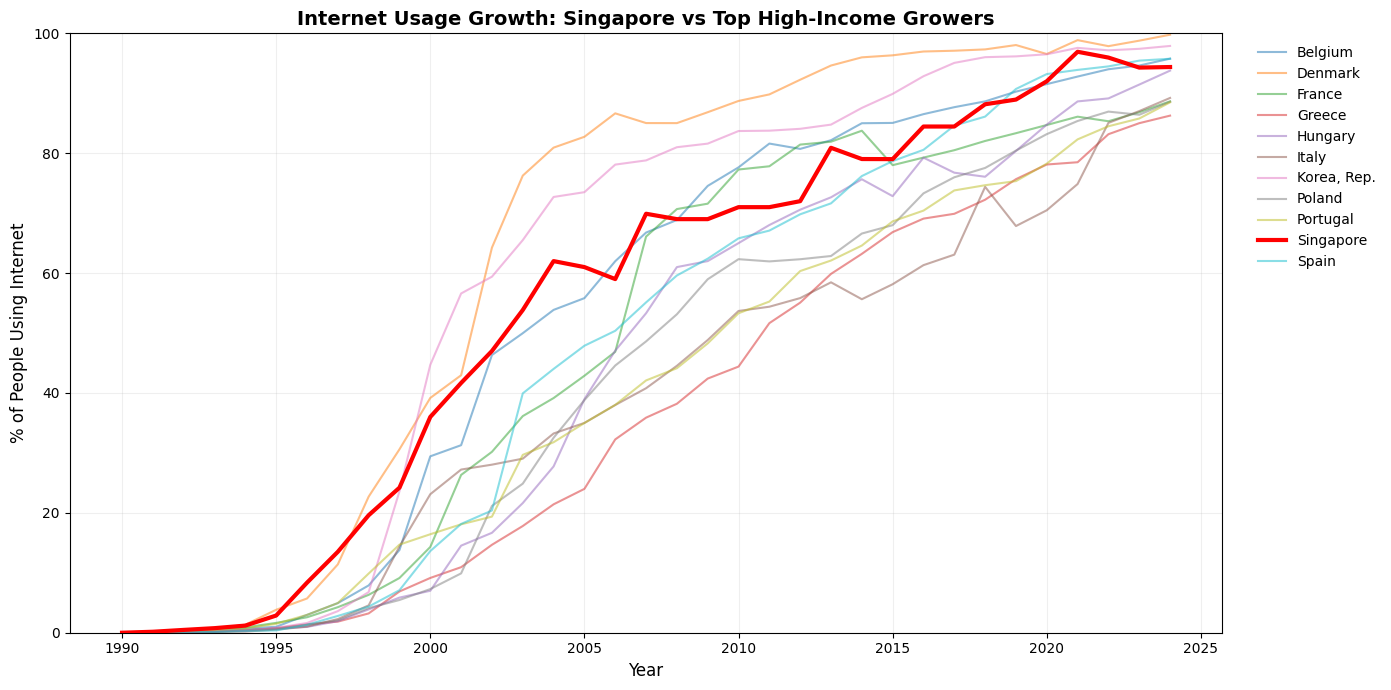

In [15]:
pdf = final_data.to_pandas()

plt.figure(figsize=(14, 7))

for country, group in pdf.groupby("Country Name"):
    
    group = group.sort_values("Year")
    
    if country == "Singapore":
        plt.plot(
            group["Year"],
            group["Value"],
            color="red",
            linewidth=3,
            label="Singapore",
            zorder=5
        )
    else:
        plt.plot(
            group["Year"],
            group["Value"],
            alpha=0.5,
            linewidth=1.5,
            label=country
        )

plt.xlabel("Year", fontsize=12)
plt.ylabel("% of People Using Internet", fontsize=12)
plt.title(
    "Internet Usage Growth: Singapore vs Top High-Income Growers",
    fontsize=14,
    weight="bold"
)

plt.ylim(0, 100)
plt.grid(alpha=0.2)

# Move legend outside so it stays clean
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

plt.tight_layout()
# plt.savefig(pathlib.Path("./Internet_usage_by_countries"), transparent=True)
plt.show()